This notebook contains some extra analysis for the coordination number of the simulation 400^3 R=12nm in the paper "Unravelling densification during sintering by multiscale modelling of grain motion" by Seiz et al (2023).

In [1]:
%matplotlib inline
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import pandas as pd
mpl.rcParams.update({"axes.grid" : True})
mpl.rcParams.update({"axes.grid" : True})
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (8,5)

In [2]:
numph = 3445 + 1 # grains + 1 vapour = 0; vapour is not counted for contacts
dist=32 # ~ 2.5 particle layers for r12
densdf = pd.read_csv("data/pack400_dx0.1_r12_mu0_weno_md_mpt_density.dat", sep=" ")
coms = np.load("data/pack400_dx0.1_r12_mu0_weno_md_mpt_comss.npy")
time, dens = densdf["time"], densdf["density"] # both are nondimensional
# json was simply chosen as the most portable format for a dict
# even though it comes with a lot of syntax bloat in this case
with open("data/ncounts.json", "r") as tmp:
    ncounts = json.load(tmp)
with open("data/surfs.json", "r") as tmp:
    surfs = json.load(tmp)

ncounts and surfs are lists of dictionaries describing the contacts between grains and their contact area, as determined by cc3d.contacts(). For each entry in the list, the dict contains all contacts which exist from both sides. Hence `ncounts[0][k1][k2] == ncounts[0][k2][k1]`.

The coordination number is determined by counting the contacts with a contact area (shared faces) larger than `MINAREA`. The results in the paper are for `MINAREA=0`, but e.g. `MINAREA=3**2` gives a curve quite close to German's literature fit.

We also filter for particle position such that the outermost particle layers are removed; these of course have a different coordination than particles within the green body.

In [3]:
nframes = len(ncounts)
MINAREAS = np.array([0, 2**2, 3**2], dtype=np.int32)
# [frame][minarea_idx][grain]
coordnum = np.zeros( (nframes, len(MINAREAS), numph), dtype=np.int32)
# this takes a while due to the (lazy) N^2 combinations and going over dicts
for frame in range(nframes):
    icoms = coms[frame]
    # exclude missing grains + vapour: these have coms at 0
    icoms_filt = icoms[np.all(icoms > 0, axis=1),:]
    mins, maxs = np.min(icoms_filt, axis=0), np.max(icoms_filt, axis=0)
    for k, v in ncounts[frame].items():
        ik = int(k) # int(k) because json dumps it as a string and conversion is longer to write
        for k2 in v.keys():
            for i, MINAREA in enumerate(MINAREAS):
                if (surfs[frame][k][k2] > MINAREA and
                np.all(icoms[ik] > mins + dist)  and
                    np.all(icoms[ik] < maxs-dist)
                   ):
                    coordnum[frame,i,ik] += 1 
                    # NB that coordnum includes zeros (vapour, surface grains, ...)
                    # which need to be eliminated before averaging

In [4]:
def filterZeros(cn):
    return cn[cn > 0] # assume that this is the innermost one

In [5]:
avgs = []
for frame in range(nframes):
    avg = []
    for i in range(len(MINAREAS)):
        cn = coordnum[frame,i]
        cn_nonzero = filterZeros(cn)
        iavg = np.average(cn_nonzero)
        avg.append(iavg)
    avgs.append(avg)
avgs = np.array(avgs)

<IPython.core.display.Javascript object>


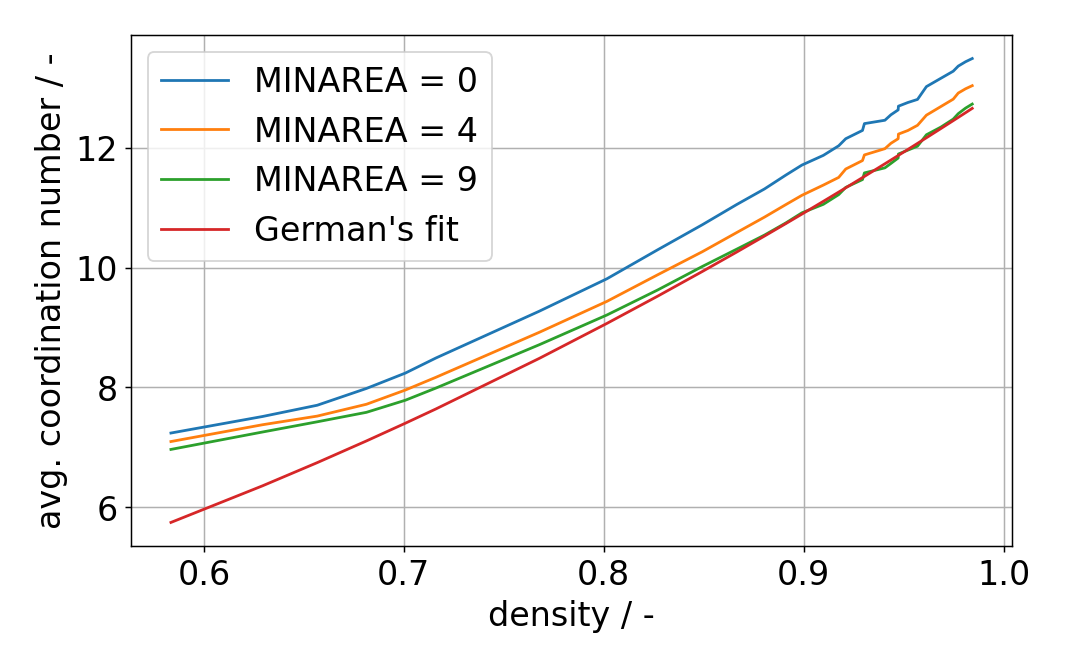

In [6]:
fig, ax = plt.subplots()
for i in range(len(MINAREAS)):
    ax.plot(dens, avgs[:,i], label="MINAREA = %d" % (MINAREAS[i]))
#ax.plot(dens, avgs[:,1], label="MINAREA = %d" % (MINAREAS[1]))
fitgerman = 2+11*dens**2
ax.plot(dens, fitgerman, label="German's fit")

ax.legend()

ax.set_xlabel("density / -")
ax.set_ylabel("avg. coordination number / -")
fig.tight_layout()
fig.savefig("avg-coord-400.pdf", bbox_inches="tight")

Note that in both cases the initial packing has a significantly higher coordination number than would be expected based on German's fit. After a transient however, the slope of the measured coordination number becomes quite similar to German's fit. This suggests that even after starting from geometrically dissimilar states, the evolution tends to move to a certain attractor, which could be the "continuous series of shapes of minimal surface area" suggested by DeHoff et al. in

DeHoff, R. T., R. A. Rummel, H. P. LaBuff, and F. N. Rhines. “The Relationship Between Surface Area and Density in the Second-Stage Sintering of Metals.” In Modern Developments in Powder Metallurgy, edited by Henry H. Hausner, 310–31. Boston, MA: Springer US, 1966. https://doi.org/10.1007/978-1-4684-7706-1_17.


Furthermore, we can determine the distribution of surface areas observed in the simulation. This is exemplarily done for the first and final frames (0, -1) in the following, but can be done for any frame.

In [7]:
framesurfs = []
frames = [0, -1]
for frame in frames:
    framesurf = []
    for g1, kdict in surfs[frame].items():
        for g2, surf in kdict.items():
            framesurf.append(surf)
    framesurfs.append(framesurf)
hists, widths, centers = [], [], []
for fsurf in framesurfs:
    hist, bins = np.histogram(fsurf, density=True, bins=100)
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2 # center the bins
    hists.append(hist)
    widths.append(width)
    centers.append(center)


<IPython.core.display.Javascript object>


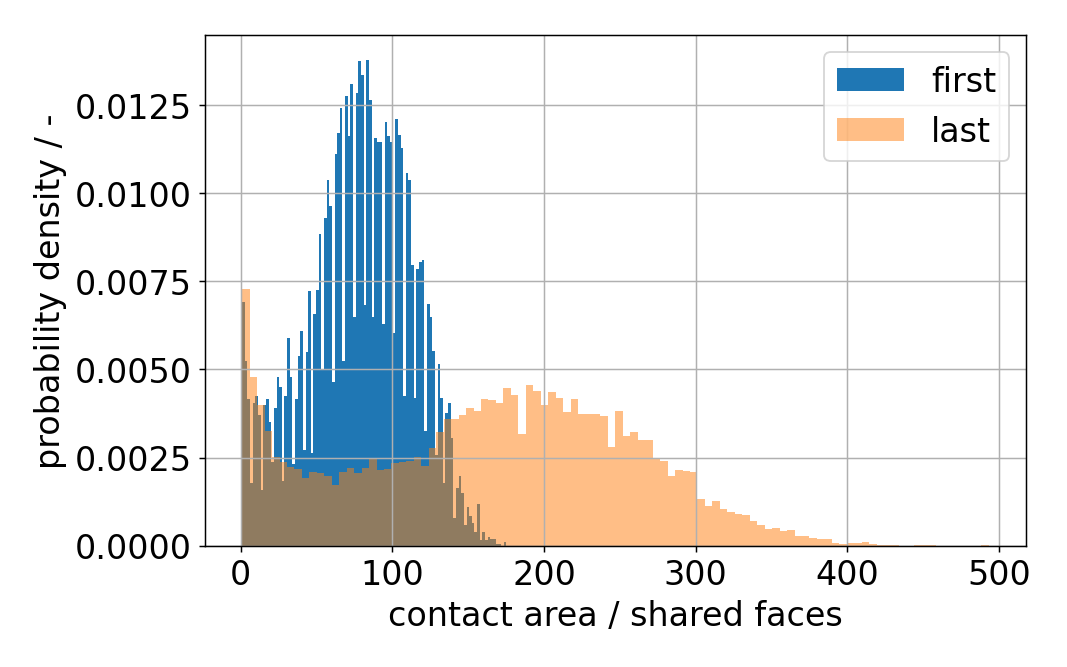

In [8]:
fig, ax = plt.subplots()
for i in range(len(frames)):
    # custom label here, if doing a series, might want to do "frame %d" % (frames[i])
    # or "t=%.2g" % (time[frames[i]]) for sim. time
    if i == 0:
        lab="first"
    if i == 1:
        lab="last"
    ax.bar(centers[i], hists[i], align="center", width=widths[i], label=lab, alpha=1-i/len(frames))
ax.legend()
ax.set_xlabel("contact area / shared faces")
ax.set_ylabel("probability density / -")
fig.tight_layout()
fig.savefig("contact-area-distri.pdf", bbox_inches="tight")

The distribution moves to larger surface area, since grain area is formed during sintering. But the distribution itself also becomes broader and tends to have its modal value at the smallest surface areas. Hence the smallest surface areas will tend to be overrepresented in the simulations, which is why a filter for these can be justified.